Use GPU:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tensorflow as tf
import keras

tf.test.gpu_device_name()

''

Install StellarGraph:

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.calibration import expected_calibration_error, plot_reliability_diagram
from stellargraph.calibration import IsotonicCalibration, TemperatureCalibration

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
from  stellargraph import StellarGraph
import pandas as pd


%matplotlib inline

Import dataset:

In [ ]:
dataset = datasets.PubMedDiabetes()

G, _ = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


Split graph into train-val-test:

In [ ]:
# train, test, validation split
train_size = 0.5 
val_size = 0.05
test_size = 0.05


edge_splitter_test = EdgeSplitter(G)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True)

edge_splitter_val = EdgeSplitter(G_test)

G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True)

edge_splitter_train = EdgeSplitter(G_val)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True)



** Sampled 2216 positive and 2216 negative edges. **
** Sampled 2106 positive and 2106 negative edges. **
** Sampled 20008 positive and 20008 negative edges. **


Train the model:

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 64
epochs = 100  # The number of training epochs for training the GraphSAGE model.

num_samples = [20, 10, 10]

train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)

layer_sizes = [16, 16, 16]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias = True, dropout=0.3)

x_inp, x_out = graphsage.in_out_tensors()

logits = link_classification(output_dim=1, output_act="elu", edge_embedding_method="ip")(x_out)

prediction = keras.layers.Activation(keras.activations.gelu)(logits)

model = keras.Model(inputs=x_inp, outputs=prediction)


model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val, shuffle = False)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, shuffle = False)

history = model.fit(train_flow,steps_per_epoch = len(train_flow), epochs= epochs, callbacks=[reduce_lr, early_stop],validation_data = val_flow, validation_steps = len(val_flow),verbose=2)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/100
626/626 - 1196s - loss: 0.5081 - accuracy: 0.7577 - val_loss: 0.4080 - val_accuracy: 0.8113 - lr: 0.0010 - 1196s/epoch - 2s/step
Epoch 2/100
626/626 - 1224s - loss: 0.4414 - accuracy: 0.8133 - val_loss: 0.3921 - val_accuracy: 0.8340 - lr: 0.0010 - 1224s/epoch - 2s/step
Epoch 3/100
626/626 - 1271s - loss: 0.4171 - accuracy: 0.8357 - val_loss: 0.3779 - val_accuracy: 0.8443 - lr: 0.0010 - 1271s/epoch - 2s/step
Epoch 4/100
626/626 - 1270s - loss: 0.3938 - accuracy: 0.8531 - val_loss: 0.3584 - val_accuracy: 0.8533 - lr: 0.0010 - 1270s/epoch - 2s/step
Epoch 5/100
626/626 - 1243s - loss: 0.3773 - accuracy: 0.8612 - val_loss: 0.3558 - val_accuracy: 0.8737 - lr: 0.0010 - 1243s/epoch - 2s/step
Epoch 6/100
626/626 - 1280s - loss: 0.3713 - accuracy: 0.8642 - val_loss: 0.3410 - val_accuracy: 0.8735 - lr: 0.0010 - 1280s/epoch - 2s/step
Epoch 7/100
626/626 - 1256s - loss: 0.4298 - accuracy: 0.8135 - val

Evaluate model:

70/70 [==============================] - 68s 970ms/step - loss: 0.3374 - accuracy: 0.8678

Train Set Metrics of the trained model:
	loss: 0.3527
	accuracy: 0.8646

Validation Set Metrics of the trained model:
	loss: 0.3481
	accuracy: 0.8699

Test Set Metrics of the trained model:
	loss: 0.3374
	accuracy: 0.8678
70/70 [==============================] - 69s 973ms/step


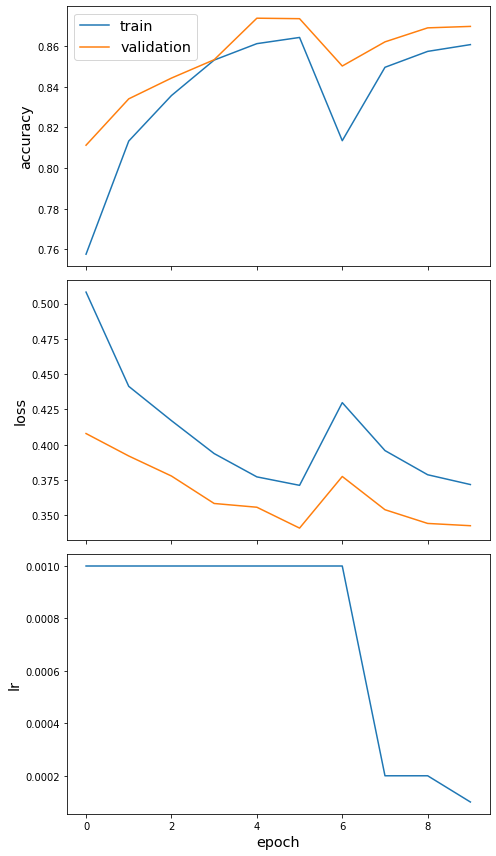

In [ ]:
sg.utils.plot_history(history)

train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


num_tests = 1  # the number of times to generate predictions

all_test_predictions = [
    model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)
]

Before calibrating, we calculate the expected calibration error on the test set:

In [ ]:
calibration_data = [calibration_curve(y_prob=test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True)
    for test_predictions in all_test_predictions]


for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_pre_calibration = expected_calibration_error(
        prediction_probabilities=all_test_predictions[0],
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,)
    print("ECE: (before calibration) {:.4f}".format(ece_pre_calibration))

ECE: (before calibration) 0.1846


We will use Platt scaling to calibrate the model:

In [ ]:
num_tests = 1
score_model = keras.Model(inputs=x_inp, outputs=logits)

all_val_score_predictions = [score_model.predict(val_flow, verbose=True) for _ in np.arange(num_tests)]
all_test_score_predictions = [score_model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)]
all_test_probabilistic_predictions = [model.predict(test_flow, verbose=True) for _ in np.arange(num_tests)]

val_predictions = np.mean(np.array(all_val_score_predictions), axis=0)

test_predictions = np.mean(np.array(all_test_score_predictions), axis=0)

# for binary classification this class performs Platt Scaling
lr = TemperatureCalibration()

lr.fit(val_predictions, edge_labels_val)

lr_test_predictions = lr.predict(test_predictions)

calibration_data = [calibration_curve(y_prob=lr_test_predictions, y_true=edge_labels_test, n_bins=10, normalize=True)]

for fraction_of_positives, mean_predicted_value in calibration_data:
    ece_post_calibration = expected_calibration_error(
        prediction_probabilities=lr_test_predictions,
        accuracy=fraction_of_positives,
        confidence=mean_predicted_value,)
    print("ECE (after calibration): {:.4f}".format(ece_post_calibration))

ECE (after calibration): 0.0117


Check how the calibration improved the model:

In [ ]:
y_pred = np.zeros(len(test_predictions))

 # the true predictions are the probabilistic outputs
test_predictions = np.mean(np.array(all_test_probabilistic_predictions), axis=0)
y_pred[test_predictions.reshape(-1) > 0.5] = 1
print("Accuracy of model before calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)))

Accuracy of model before calibration: 0.87


In [ ]:
y_pred = np.zeros(len(lr_test_predictions))
y_pred[lr_test_predictions[:, 0] > 0.5] = 1
print("Accuracy for model after calibration: {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=edge_labels_test)))

Accuracy for model after calibration: 0.88
